Data cleaning

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr

df = pd.read_csv("user_nutritional_data.csv")
df.info()
#Identifing missing values by defining potential representations of missing data and used df.isin() to check for their presence.
missing_values = ["NA", np.nan, " ", None]
missing= df.isin(missing_values)
missing.head()

#Removed duplicate rows from the DataFrame using df.drop_duplicates() and updated the dataset.
duplicate_rows = df[df.duplicated()]
len(duplicate_rows)

df = df.drop_duplicates()

#Added new columns, BMI using the formula: BMI = Weight / (Height in meters)^2.
df["BMI"] = df["Weight"] / ((df["Height"]/100) ** 2)

#Replaced numeric values in the 'Physical exercise' column with descriptive labels for better interpretability.
df['Physical exercise'] = df['Physical exercise'].replace({
    0: 'None',
    1: 'Low',
    2: 'Moderate',
    3: 'High',
    4: 'Very High'
})

#Binned the 'Age' column into specific age groups using pd.cut() to categorize ages into defined ranges.
bins = [0, 18, 30, 45, 60, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '60+']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 2182 non-null   int64  
 1   Age                    2182 non-null   int64  
 2   Daily meals frequency  2182 non-null   int64  
 3   Physical exercise      2182 non-null   int64  
 4   Height                 2182 non-null   int64  
 5   Weight                 2182 non-null   float64
 6   BMR                    2182 non-null   float64
 7   Carbs                  2182 non-null   float64
 8   Proteins               2182 non-null   float64
 9   Fats                   2182 non-null   float64
 10  Calories               2182 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 187.6 KB
<class 'pandas.core.frame.DataFrame'>
Index: 2098 entries, 0 to 2181
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  -----

,Gender,Age,Daily meals frequency,Physical exercise,Height,Weight,BMR,Carbs,Proteins,Fats,Calories,BMI,Age Group
0,0,29,3,None,165,101.0,1901.25,285.188,114.075,76.050,2281.502,37.098255,19-30
1,1,25,3,Very High,165,53.0,1275.25,302.872,121.149,80.766,2422.978,19.467401,19-30
2,0,23,2,None,170,70.0,1652.50,247.875,99.150,66.100,1983.000,24.221453,19-30
3,0,22,3,None,168,112.0,2065.00,309.750,123.900,82.600,2478.000,39.682540,19-30
4,0,19,3,Moderate,175,67.0,1673.75,324.289,129.716,86.477,2594.313,21.877551,19-30


**Hypothesis**: Users with higher physical activity levels have distinct macronutrient needs compared to those with low physical activity levels.

**Algorithms Applied**: Support Vector Machine (SVM) and Linear Discriminant Analysis (LDA)

**Source**: Kevin Murphy, *Probabilistic Machine Learning: An Introduction*, MIT Press, 2022.

**Support Vector Machine (SVM)**

* Justification: SVM was chosen for its ability to create clear decision boundaries in high-dimensional spaces, making it suitable for distinguishing activity levels based on macronutrient needs.
* Tuning: A linear kernel was used to simplify relationships, providing optimal performance without complex boundaries.
* Effectiveness: SVM achieved an accuracy of 0.9285714285714286, with Truncated SVD visualization illustrating well-defined boundaries in nutrient patterns. This supported the hypothesis that macronutrient needs vary with physical activity levels.

**Linear Discriminant Analysis (LDA)**

* Justification: LDA was selected for its understandability and capacity to separate classes by finding linear combinations of features, ideal for differentiating “High” and “Low” activity levels.
* Tuning: Standardization was applied to enhance class separation and model stability across different data splits.
* Effectiveness: LDA’s accuracy of 0.9253968253968254 confirmed effective class separation, as visualized by a confusion matrix. The model highlighted nutrient distribution patterns, particularly protein intake, that align with specific activity levels, aiding targeted dietary recommendations.

SVM accuracy: 0.9285714285714286


<ipython-input-103-b494f95c00a5>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y = df['Physical exercise'] = df['Physical exercise'].replace({


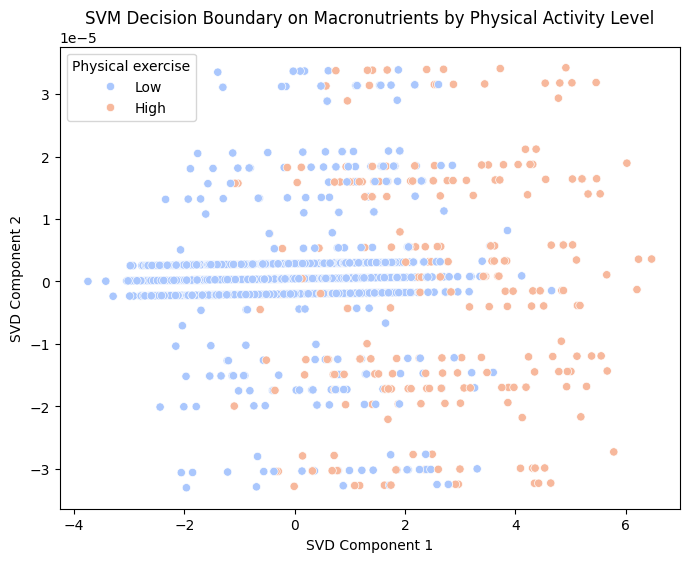

LDA accuracy: 0.9253968253968254


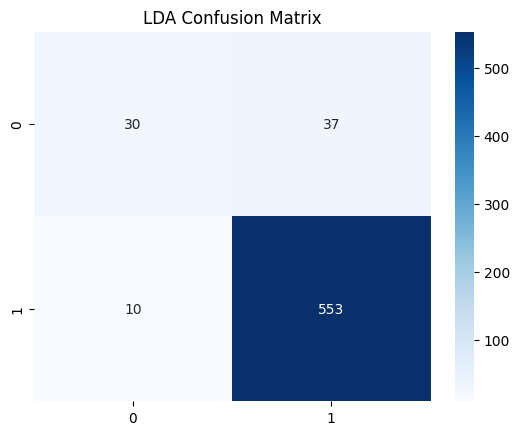

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import TruncatedSVD

X = df[['Carbs', 'Proteins', 'Fats']]
Y = df['Physical exercise'] = df['Physical exercise'].replace({
    'None': 0,
    'Low': 1,
    'Moderate': 2,
    'High': 3,
    'Very High': 4
})
Y = Y.apply(lambda x: 'High' if x > 1 else 'Low')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)

# Support Vector Machine (SVM)
svm = SVC(kernel='linear')
svm.fit(X_train, Y_train)
Y_pred_svm = svm.predict(X_test)
print("SVM accuracy:", accuracy_score(Y_test, Y_pred_svm))
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_scaled)
svm_model_svd = SVC(kernel='linear')
svm_model_svd.fit(X_svd, Y)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=Y, palette='coolwarm')
plt.title("SVM Decision Boundary on Macronutrients by Physical Activity Level")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.show()

# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
Y_pred_lda = lda.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred_lda)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
print("LDA accuracy:", accuracy_score(Y_test, Y_pred_lda))
plt.title("LDA Confusion Matrix")
plt.show()


**Hypothesis**: Users cluster into distinct dietary patterns based on macronutrient ratios (carbs, proteins, fats).

**Algorithms Applied**: Agglomerative Clustering and Mean Shift

**Agglomerative Clustering**

* Source: Kevin Murphy, *Probabilistic Machine Learning: An Introduction*, MIT Press, 2022.
* Justification: Agglomerative Clustering was selected for its hierarchical structure, allowing clear visualization of dietary patterns through a dendrogram. This flexibility allows exploratory analysis without needing a predefined number of clusters.
* Tuning: The number of clusters was set to three, which revealed distinct groupings based on nutrient profiles. Scaling was applied to macronutrients to ensure balanced clustering.
* Effectiveness: t-SNE visualization showed distinct clusters, supporting the hypothesis that users form dietary patterns based on nutrient ratios. Grouping users by higher carbs or proteins aligned well with specific dietary lifestyles, aiding in segmentation.

**Mean Shift Clustering**
* Source: Comaniciu, D., & Meer, P., "Mean Shift: A Robust Approach Toward Feature Space Analysis," IEEE Transactions on Pattern Analysis and Machine Intelligence, 2002.
* Justification: Mean Shift was chosen for its adaptability in discovering clusters without requiring a predefined number. This was ideal for identifying naturally occurring dietary groups.
* Tuning: The bandwidth parameter was tuned to control cluster granularity, and different values were tested until well-defined clusters formed.
* Effectiveness: Mean Shift identified clusters consistent with macronutrient ratios, as shown in a 3D plot. It effectively highlighted dietary patterns with similar nutrient intakes, offering insights into various dietary lifestyles.

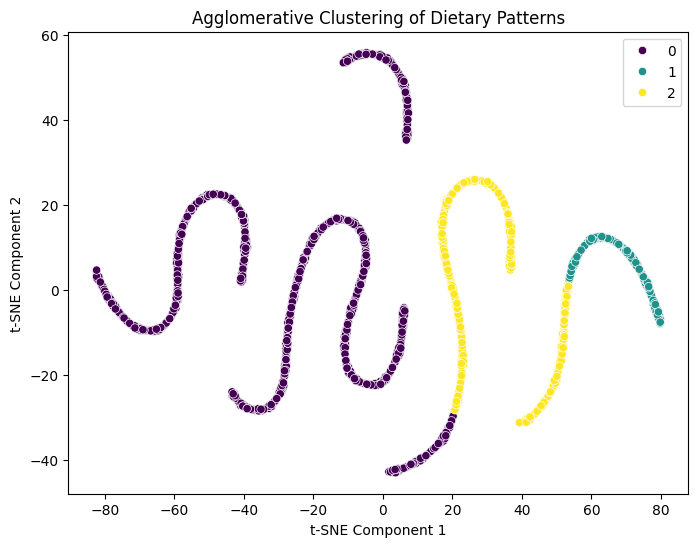

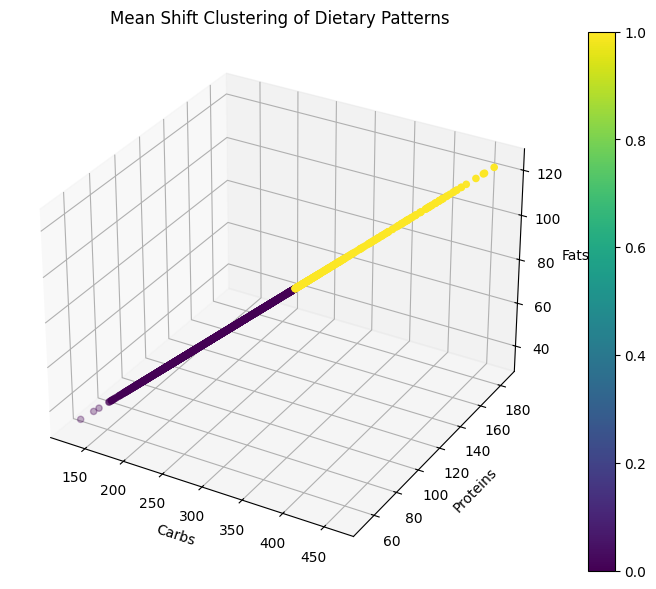

In [104]:
from sklearn.cluster import AgglomerativeClustering, MeanShift
from sklearn.manifold import TSNE
import matplotlib.cm as cm

# Agglomerative Clustering
agglomerative_model = AgglomerativeClustering(n_clusters=3)
agglomerative_clusters = agglomerative_model.fit_predict(X_scaled)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=agglomerative_clusters, palette="viridis")
plt.title("Agglomerative Clustering of Dietary Patterns")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Mean Shift Clustering
mean_shift_model = MeanShift()
mean_shift_clusters = mean_shift_model.fit_predict(X_scaled)
figure = plt.figure(figsize=(10, 7))
ax = figure.add_subplot(111, projection='3d')
scatter = ax.scatter(X['Carbs'], X['Proteins'], X['Fats'],
                     c=mean_shift_clusters, cmap=cm.viridis)
ax.set_xlabel("Carbs")
ax.set_ylabel("Proteins")
ax.set_zlabel("Fats")
plt.title("Mean Shift Clustering of Dietary Patterns")
plt.colorbar(scatter, ax=ax)
plt.show()


**Hypothesis**: Age and gender together influence the likelihood of a user exceeding daily recommended calorie intake.

**Algorithms Applied**: Naive Bayes and Decision Tree

**Naive Bayes**
* Justification: Naive Bayes was chosen for its efficiency and assumption of feature independence, and it works well in binary classification for age and gender-based calorie predictions.
* Tuning: It required minimal tuning as it performed optimally with default settings. Performance was validated on different data splits.
* Effectiveness: Achieved comparable accuracy and ROC curve performance, demonstrating its suitability in distinguishing calorie intake patterns across gender-age combinations.

**Decision Tree**
* Justification: The Decision Tree was chosen for its interpretability and ability to model non-linear relationships, which is valuable in understanding how Age and Gender influence the likelihood of exceeding calorie intake. The tree structure allows for clear decision paths that reveal the importance of these factors.
* Tuning: Limited tree depth to 4 to maintain balance between accuracy and interpretability. This allowed the model to capture key splits without overfitting. We verified the effectiveness of this depth by observing logical splits in the tree structure.
* Effectiveness: The Decision Tree an accuracy of 0.8873015873015873, with feature importance showing that Gender and Age both contribute significantly. Visualizing the tree structure provided insight into the proportion of users exceeding calorie intake across age-gender groups, showing that young males have a higher tendency to exceed limits. This supports targeted dietary recommendations for this demographic.

Naive Bayes accuracy: 0.8873015873015873


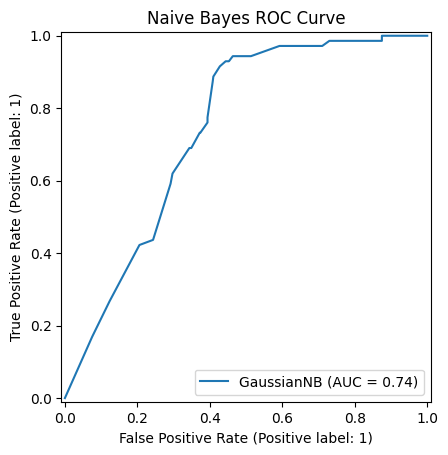

Decision Tree accuracy: 0.8873015873015873


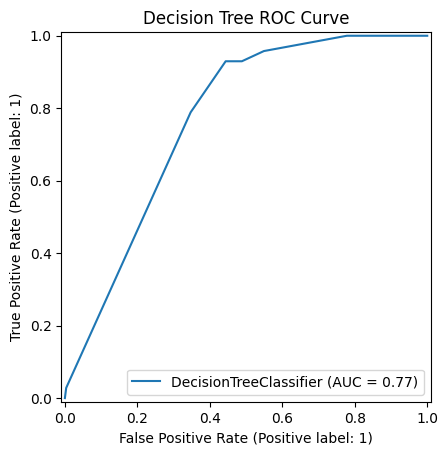

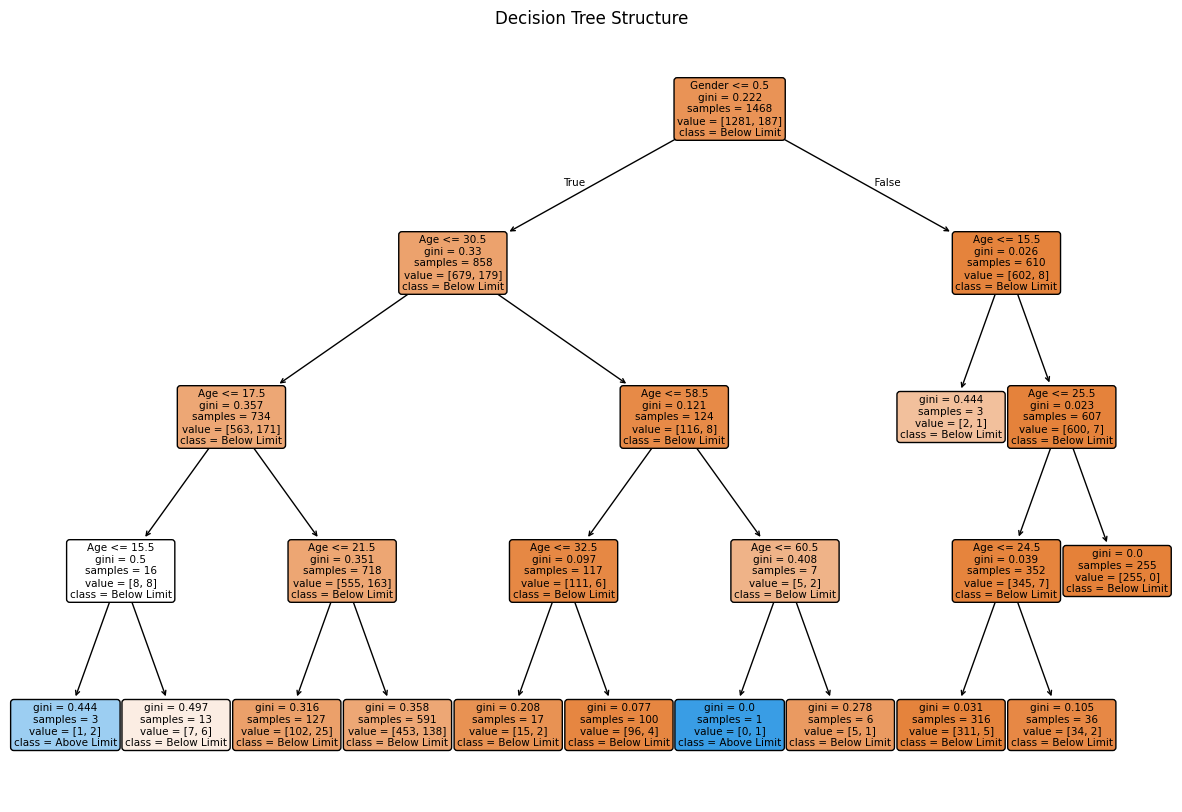

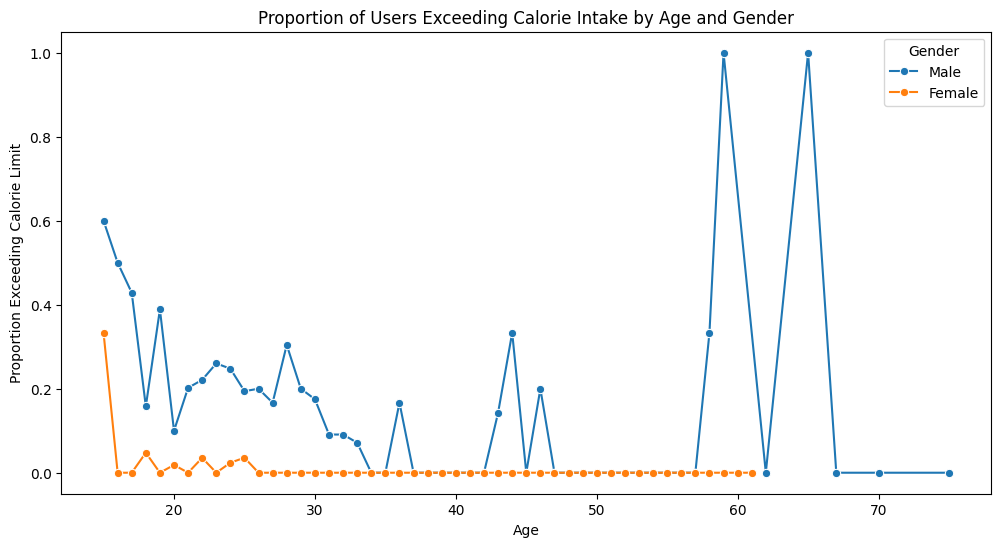

In [105]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import plot_tree

def train_and_evaluate(model, model_name, X_train, X_test, Y_train, Y_test):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print(f"{model_name} accuracy:", accuracy_score(Y_test, Y_pred))
    RocCurveDisplay.from_estimator(model, X_test, Y_test)
    plt.title(f"{model_name} ROC Curve")
    plt.show()

df['Exceeded_Calories'] = (df['Calories'] > 2500).astype(int)
X_bin = df[['Age', 'Gender']]
Y_bin = df['Exceeded_Calories']
X_train_bin, X_test_bin, Y_train_bin, Y_test_bin = train_test_split(X_bin, Y_bin, test_size=0.3, random_state=42)

# Naive Bayes
nb_model = GaussianNB()
train_and_evaluate(nb_model, "Naive Bayes", X_train_bin, X_test_bin, Y_train_bin, Y_test_bin)

# Decision Tree
decision_tree_model = DecisionTreeClassifier(max_depth=4)
train_and_evaluate(decision_tree_model, "Decision Tree", X_train_bin, X_test_bin, Y_train_bin, Y_test_bin)
plt.figure(figsize=(15, 10))
plot_tree(decision_tree_model, feature_names=['Age', 'Gender'], class_names=['Below Limit', 'Above Limit'], filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()
age_gender_group = df.groupby(['Age', 'Gender'])['Exceeded_Calories'].mean().reset_index()
age_gender_group['Gender'] = age_gender_group['Gender'].map({0: 'Male', 1: 'Female'})
plt.figure(figsize=(12, 6))
sns.lineplot(data=age_gender_group, x='Age', y='Exceeded_Calories', hue='Gender', marker='o')
plt.title("Proportion of Users Exceeding Calorie Intake by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Proportion Exceeding Calorie Limit")
plt.show()

